# Automated Essay Scoring 

### What is this Notebook about?

- This Notebook contains all raw results and experiments done with the various deep learning methods. The output cells contains the results that we got. The whole Notebook may take approximately 5-6 hours. This Notebook contains the following:

* Preprocess data
* Important util methods to be used later
* Deep Learning Model declaration
* Running bert for individual sets
* Running bert for whole dataset
* Running word2vec for individual sets
* Running word2vec for whole dataset

In [1]:
# import important libraries and download data
import os
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import multiprocessing
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  
! git clone https://github.com/Gaurav-Pande/AES_DL.git && mv AES_DL/data .
! pip install transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Cloning into 'AES_DL'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 4), reused 13 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [0]:
# Declaring some visualization methods to plot accuracy and model diagram
def plot_accuracy_curve(history):
  import matplotlib.pyplot as plt
  plt.plot(history.history['loss'])
  plt.plot(history.history['mae'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

def plot_acrchitecture(filename, model):
  from keras.utils import plot_model
  plot_model(model, to_file=str(filename) + '.png')

In [0]:
# method to split data into sets
def split_in_sets(data):
    essay_sets = []
    min_scores = []
    max_scores = []
    for s in range(1,9):
        essay_set = data[data["essay_set"] == s]
        essay_set.dropna(axis=1, inplace=True)
        n, d = essay_set.shape
        set_scores = essay_set["domain1_score"]
        print ("Set", s, ": Essays = ", n , "\t Attributes = ", d)
        min_scores.append(set_scores.min())
        max_scores.append(set_scores.max())
        essay_sets.append(essay_set)
    return (essay_sets, min_scores, max_scores)

In the below cell, we can see the data we need to operate. We essentially drops the column, we dont need and keep the domain_score only along with essay text.

In [7]:
dataset_path = "./data/training_set_rel3.tsv"
data = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1")
min_scores = [2, 1, 0, 0, 0, 0, 0, 0]
max_scores = [12, 6, 3, 3, 4, 4, 30, 60]
essay_sets, data_min_scores, data_max_scores = split_in_sets(data)
set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
data.dropna(axis=1, inplace=True)
data.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set1.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set2.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set3.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set4.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set5.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set6.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set7.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set8.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
sets = [set1,set2,set3,set4,set5,set6,set7,set8]
data.head()

Set 1 : Essays =  1783 	 Attributes =  6
Set 2 : Essays =  1800 	 Attributes =  9
Set 3 : Essays =  1726 	 Attributes =  6
Set 4 : Essays =  1770 	 Attributes =  6
Set 5 : Essays =  1805 	 Attributes =  6
Set 6 : Essays =  1800 	 Attributes =  6
Set 7 : Essays =  1569 	 Attributes =  14
Set 8 : Essays =  723 	 Attributes =  18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


 There are named entity tags as you can see above, which can impact our model. so we need to remove them from the dataframe. So we will extend our stopwords set later on. But first we need to create all possible ner tags.

In [0]:
cap = ['@CAPS'+str(i) for i in range(100)]
loc = ['@LOCATION'+str(i) for i in range(100)]
org =['@ORGANIZATION'+str(i) for i in range(100)]
per = ['@PERSON'+str(i) for i in range(100)]
date = ['@DATE'+str(i) for i in range(100)]
time = ['@TIME'+str(i) for i in range(100)]
money = ['@MONEY'+str(i) for i in range(100)]
ner =  cap + loc + org + per + date + time + money

Some utility functions declarations needed to convert the raw essay to word list.

In [0]:
import collections
top10 = collections.defaultdict(int)
def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    #top10 = collections.defaultdict(int)
    if remove_stopwords:
        stops = stopwords.words("english")
        stops.extend(ner)
        for word in words:
          if word not in stops:
            # words.append(w)
            top10[word]+=1
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

Below we declare the model. here the model is of older version. for running the most recent version please refer to readme, which inputs the model_type as well in terms of hyperparameter.

In [10]:
from keras.layers import Embedding, Input, LSTM, Dense, Dropout, Lambda, Flatten, Bidirectional, Conv2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential,Model, load_model, model_from_config
import keras.backend as K

def get_model(Hidden_dim1=400, Hidden_dim2=128, return_sequences = True, dropout=0.5, recurrent_dropout=0.4, input_size=768, activation='relu', bidirectional = False):
    """Define the model."""
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(Hidden_dim1,return_sequences=return_sequences , dropout=0.4, recurrent_dropout=recurrent_dropout), input_shape=[1, input_size]))
        model.add(Bidirectional(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout)))
    else:
        model.add(LSTM(Hidden_dim1, dropout=0.4, recurrent_dropout=recurrent_dropout, input_shape=[1, input_size], return_sequences=return_sequences))
        model.add(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation=activation))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model

def get_model_CNN(Hidden_dim1=400, Hidden_dim2=128, return_sequences = True, dropout=0.5, recurrent_dropout=0.4, input_size=768,output_dims=10380, activation='relu', bidirectional = False):
    """Define the model."""
    inputs = Input(shape=(768,1))
    x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)
    #Cuts the size of the output in half, maxing over every 2 inputs
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
    x = GlobalMaxPooling1D()(x) 
    outputs = Dense(output_dims, activation='relu')(x)
    model = Model(inputs=inputs, outputs=outputs, name='CNN')
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mse'])
    model.summary()
    return model

Using TensorFlow backend.


Below we will run the model for all sets using BERT

In [0]:
## Sets experiment BERT
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
set_count = 1
all_sets_score = []
for s in sets:
  print("\n--------SET {}--------\n".format(set_count))
  X = s
  y = s['domain1_score']
  cv = KFold(n_splits=5, shuffle=True)
  cv_data = cv.split(X)
  results = []
  prediction_list = []
  fold_count =1
  cuda = torch.device('cuda')
  # For DistilBERT:
  model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
  ## Want BERT instead of distilBERT? Uncomment the following line:
  ##model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
  # Load pretrained model/tokenizer
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights)
  with torch.cuda.device(cuda):
    for traincv, testcv in cv_data:
      torch.cuda.empty_cache()
      print("\n--------Fold {}--------\n".format(fold_count))
      # get the train and test from the dataset.
      X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
      train_essays = X_train['essay']
      #print("y_train",y_train)
      test_essays = X_test['essay']
      # model = model.cuda()
      #y_train = torch.tensor(y_train,dtype=torch.long)
      sentences = []
      tokenize_sentences = []
      train_bert_embeddings = []
      #bert_embedding = BertEmbedding()
      # for essay in train_essays:
      #   # get all the sentences from the essay
      #   sentences += essay_to_sentences(essay, remove_stopwords = True)
      # sentences = pd.Series(sentences)
      # print(train_essays)
      tokenized_train = train_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200)))
      tokenized_test = test_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200)))


      ## train
      max_len = 0
      for i in tokenized_train.values:
        if len(i) > max_len:
          max_len = len(i)
      padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])

      attention_mask_train = np.where(padded_train != 0, 1, 0)



      train_input_ids = torch.tensor(padded_train)
      train_attention_mask = torch.tensor(attention_mask_train)
      with torch.no_grad():
        last_hidden_states_train = model(train_input_ids, attention_mask=train_attention_mask)


      train_features = last_hidden_states_train[0][:,0,:].numpy()
      

      ## test
      max_len = 0
      for i in tokenized_test.values:
        if len(i) > max_len:
          max_len = len(i)
      padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
      attention_mask_test = np.where(padded_test != 0, 1, 0)
      test_input_ids = torch.tensor(padded_test)  
      test_attention_mask = torch.tensor(attention_mask_test)

      with torch.no_grad():
        last_hidden_states_test = model(test_input_ids, attention_mask=test_attention_mask)

      test_features = last_hidden_states_test[0][:,0,:].numpy()
      



      train_x,train_y = train_features.shape
      test_x,test_y = test_features.shape

      trainDataVectors = np.reshape(train_features,(train_x,1,train_y))
      testDataVectors = np.reshape(test_features,(test_x,1,test_y))

      lstm_model = get_model(bidirectional=False)
      lstm_model.fit(trainDataVectors, y_train, batch_size=128, epochs=70)
      y_pred = lstm_model.predict(testDataVectors)

      y_pred = np.around(y_pred)
      #y_pred.dropna()
      np.nan_to_num(y_pred)
      # evaluate the model
      result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
      print("Kappa Score: {}".format(result))
      results.append(result)
      fold_count +=1
      import tensorflow as tf
      tf.keras.backend.clear_session()



  all_sets_score.append(results)
  print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
  set_count+=1
    # print(features.shape)


--------SET 1--------



Streaming output truncated to the last 5000 lines.
1440/1440 [==============================] - 0s 69us/step - loss: 0.3962 - mae: 0.5002
Epoch 65/70
1440/1440 [==============================] - 0s 78us/step - loss: 0.4177 - mae: 0.5207
Epoch 66/70
1440/1440 [==============================] - 0s 69us/step - loss: 0.3892 - mae: 0.4967
Epoch 67/70
1440/1440 [==============================] - 0s 66us/step - loss: 0.4168 - mae: 0.5103
Epoch 68/70
1440/1440 [==============================] - 0s 69us/step - loss: 0.4330 - mae: 0.5330
Epoch 69/70
1440/1440 [==============================] - 0s 71us/step - loss: 0.4401 - mae: 0.5280
Epoch 70/70
1440/1440 [==============================] - 0s 76us/step - loss: 0.4151 - mae: 0.5201
Kappa Score: 0.3938867963827608

--------Fold 5--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 400)            18

Below we will run for whole dataset using BERT but using CNN, which didnt performed so well.



--------Fold 1--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            2565600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10380/10380 [==============================] - 5s 527us/step - loss: 38.7916 - mae: 3.4809 - mse: 38.7916
Epoch 2/100
10380/10380 [==============================] - 4s 357us/step - loss: 22.0969 - mae: 2.

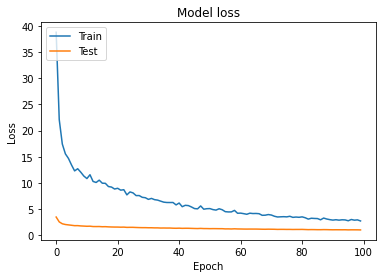

[[ 9.]
 [ 8.]
 [ 9.]
 ...
 [38.]
 [29.]
 [38.]]
Kappa Score: 0.9239790570710182

--------Fold 2--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            2565600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10381/10381 [==============================] - 5s 522us/step - loss: 40.6611 - mae: 3.5470 - mse: 40.6611
Epoch 2/100
10381/1

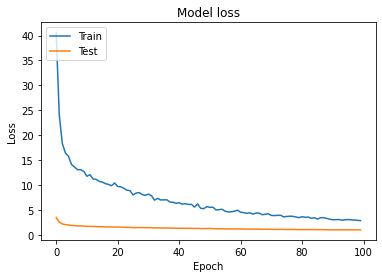

[[ 8.]
 [ 9.]
 [10.]
 ...
 [26.]
 [29.]
 [ 5.]]
Kappa Score: 0.9450567379796316

--------Fold 3--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            2565600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10381/10381 [==============================] - 5s 504us/step - loss: 39.2819 - mae: 3.4838 - mse: 39.2819
Epoch 2/100
10381/1

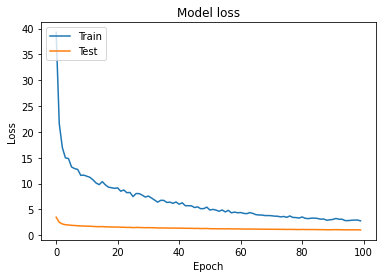

[[ 8.]
 [ 9.]
 [ 8.]
 ...
 [41.]
 [30.]
 [34.]]
Kappa Score: 0.9256860865252433

--------Fold 4--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            2565600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10381/10381 [==============================] - 5s 505us/step - loss: 37.7470 - mae: 3.4443 - mse: 37.7470
Epoch 2/100
10381/1

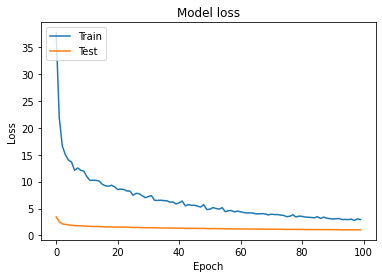

[[ 9.]
 [10.]
 [ 6.]
 ...
 [42.]
 [35.]
 [10.]]
Kappa Score: 0.9236147722479966

--------Fold 5--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            2565600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10381/10381 [==============================] - 5s 502us/step - loss: 38.7174 - mae: 3.4607 - mse: 38.7174
Epoch 2/100
10381/1

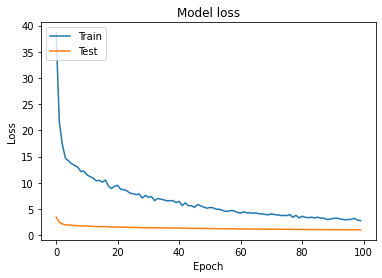

[[ 9.]
 [ 9.]
 [11.]
 ...
 [16.]
 [20.]
 [20.]]
Kappa Score: 0.9193338813957616
Average kappa score value is : 0.9275341070439304


In [12]:
 # For whole dataset
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
cv = KFold(n_splits=5, shuffle=True)
# X = set8
# y = set8['domain1_score']
X= data
y = data['domain1_score']
cv_data = cv.split(X)
results = []
prediction_list = []
fold_count =1
# use_cuda = True
# if use_cuda and torch.cuda.is_available():
#   torch.cuda()
# Hyperpaprameters for LSTM
Hidden_dim1=300
Hidden_dim2=100
return_sequences = True
dropout=0.5
recurrent_dropout=0.4
input_size=768
activation='relu'
bidirectional = True
batch_size = 64
epoch = 100
#####
cuda = torch.device('cuda')
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
## Want BERT instead of distilBERT? Uncomment the following line:
##model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
with torch.cuda.device(cuda):
  for traincv, testcv in cv_data:
    torch.cuda.empty_cache()
    print("\n--------Fold {}--------\n".format(fold_count))
    # get the train and test from the dataset.
    X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
    train_essays = X_train['essay']
    #print("y_train",y_train)
    test_essays = X_test['essay']
    # model = model.cuda()
    #y_train = torch.tensor(y_train,dtype=torch.long)
    sentences = []
    tokenize_sentences = []
    train_bert_embeddings = []
    #bert_embedding = BertEmbedding()
    # for essay in train_essays:
    #   # get all the sentences from the essay
    #   sentences += essay_to_sentences(essay, remove_stopwords = True)
    # sentences = pd.Series(sentences)
    # print(train_essays)
    tokenized_train = train_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=55)))
    tokenized_test = test_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=55)))


    ## train
    max_len = 0
    for i in tokenized_train.values:
      if len(i) > max_len:
        max_len = len(i)
    padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])

    attention_mask_train = np.where(padded_train != 0, 1, 0)



    train_input_ids = torch.tensor(padded_train)
    train_attention_mask = torch.tensor(attention_mask_train)
    with torch.no_grad():
      last_hidden_states_train = model(train_input_ids, attention_mask=train_attention_mask)


    train_features = last_hidden_states_train[0][:,0,:].numpy()
    

    ## test
    max_len = 0
    for i in tokenized_test.values:
      if len(i) > max_len:
        max_len = len(i)
    padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
    attention_mask_test = np.where(padded_test != 0, 1, 0)
    test_input_ids = torch.tensor(padded_test)  
    test_attention_mask = torch.tensor(attention_mask_test)

    with torch.no_grad():
      last_hidden_states_test = model(test_input_ids, attention_mask=test_attention_mask)

    test_features = last_hidden_states_test[0][:,0,:].numpy()
    train_x,train_y = train_features.shape
    test_x,test_y = test_features.shape
    trainDataVectors = np.reshape(train_features,(train_x,1,train_y))
    testDataVectors = np.reshape(test_features,(test_x,1,test_y))
    # print(trainDataVectors)
    # print(testDataVectors)
    # trainDataVectors = np.reshape(train_features,(train_x,train_y,1))
    # testDataVectors = np.reshape(test_features,(test_x,test_y,1))
    trainDataVectors = np.reshape(train_features,(train_x,1, train_y))
    testDataVectors = np.reshape(test_features,(test_x,1, test_y))
    # lstm_model = get_model_CNN(bidirectional=False, output_dims = 1)
    lstm_model = get_model(Hidden_dim1=Hidden_dim1, Hidden_dim2=Hidden_dim2, return_sequences=return_sequences,
                            dropout=dropout, recurrent_dropout=recurrent_dropout, input_size=input_size,
                            activation=activation, bidirectional=bidirectional)
    history = lstm_model.fit(trainDataVectors, y_train, batch_size=batch_size, epochs=epoch)
    plot_accuracy_curve(history)
    y_pred = lstm_model.predict(testDataVectors)
    y_pred = np.around(y_pred)
    #y_pred.dropna()
    np.nan_to_num(y_pred)
    # evaluate the model
    print(y_pred)
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    fold_count +=1
    import tensorflow as tf
    tf.keras.backend.clear_session()
print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
  # print(features.shape)

In [0]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [0]:
trainDataVectors = np.reshape(train_features,(train_x,train_y,1))
testDataVectors = np.reshape(test_features,(test_x,test_y,1))
print(y_train.shape)
print(trainDataVectors.shape)

(10380,)
(10380, 768, 1)


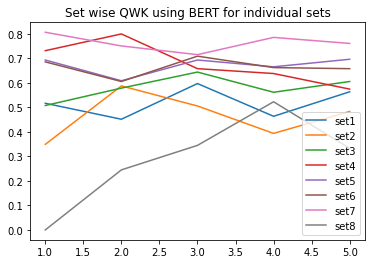

In [0]:
# x = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
def plot_qwk_scores_all_sets():
  fig = plt.figure()
  ax = plt.subplot(111)
  x = [1,2,3,4,5]
  ax.plot(x, set1 , label='set1')
  ax.plot(x, set2, label='set2')
  ax.plot(x, set3, label='set3')
  ax.plot(x, set4, label='set4')
  ax.plot(x, set5, label='set5')
  ax.plot(x, set6, label='set6')
  ax.plot(x, set7, label='set7')
  ax.plot(x, set8, label='set8')
  plt.title('Set wise QWK using BERT for individual sets')
  ax.legend()
  plt.show()


Buildind word2vec model method to render the text and convert to word2vec feature vector.

In [0]:
def build_word2vec(train_sentences, num_workers, num_features, min_word_count, context,
                     downsampling):
    model = Word2Vec(workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                     sample=downsampling)
    # saving the word2vec model
    # model.wv.save_word2vec_format('word2vec_'+ str(fold_count) +'.bin', binary=True)
    cores = multiprocessing.cpu_count()
    print("\n {} cores using".format(cores))
    start_time = time.time()
    model.build_vocab(train_sentences, progress_per=10000)
    print('Time to build vocab using word2vec: {} sec'.format(time.time() - start_time))
    start_time = time.time()
    model.train(train_sentences, total_examples=model.corpus_count, epochs=epochs, report_delay=1)
    print('Time to train the word2vec model: {} mins'.format(time.time() - start_time))
    model.init_sims(replace=True)
    sorted_dic = sorted(top10.items(), key=lambda k: k[1], reverse=True)
    return model,sorted_dic

Below method will run on individual sets using word2vec


--------SET 1--------

(1783, 4)
(1783,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.2673826217651367 sec
Time to train the word2vec model: 9.049090385437012 mins
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoc

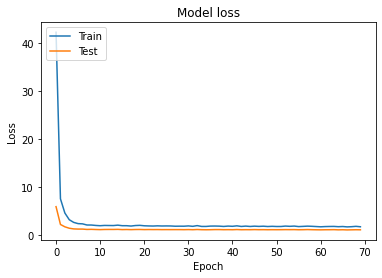

Kappa Score: 0.5088826375493651

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.2600727081298828 sec
Time to train the word2vec model: 9.034634828567505 mins
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
142

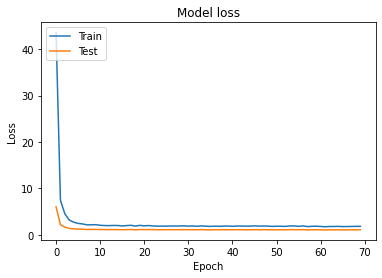

Kappa Score: 0.5837948120081609

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.26175808906555176 sec
Time to train the word2vec model: 8.970890998840332 mins
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
14

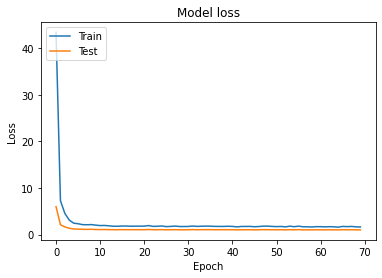

Kappa Score: 0.4902762050120625

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.2515127658843994 sec
Time to train the word2vec model: 8.912643671035767 mins
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
142

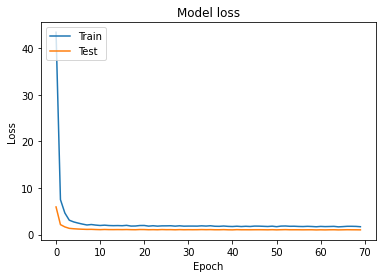

Kappa Score: 0.5271526035131744

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.25843358039855957 sec
Time to train the word2vec model: 8.947765588760376 mins
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
14

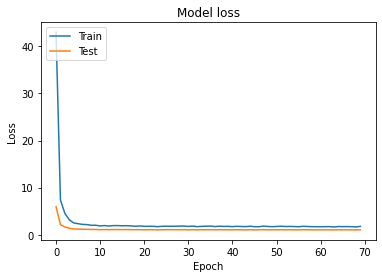

Kappa Score: 0.450233353695785
Average kappa score value is : 0.5120679223557096

--------SET 2--------

(1800, 7)
(1800,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.25551414489746094 sec
Time to train the word2vec model: 8.659111022949219 mins
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainabl

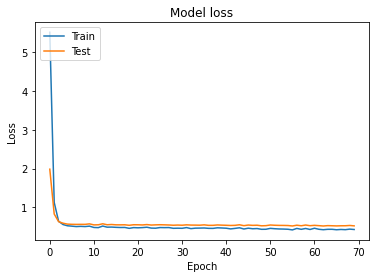

Kappa Score: 0.4659624413145539

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.2505044937133789 sec
Time to train the word2vec model: 8.646145343780518 mins
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
144

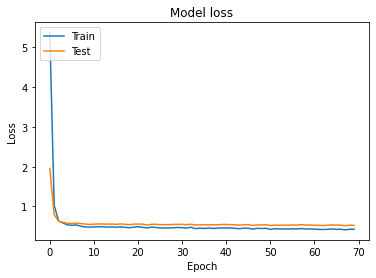

Kappa Score: 0.4787533597849737

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.25393176078796387 sec
Time to train the word2vec model: 8.690581560134888 mins
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_15 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
14

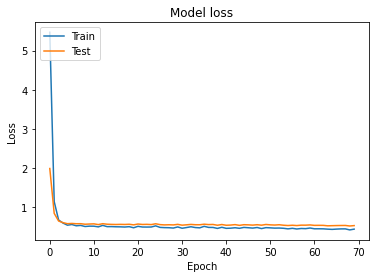

Kappa Score: 0.4062281503791749

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.25275254249572754 sec
Time to train the word2vec model: 8.501373767852783 mins
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_17 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
14

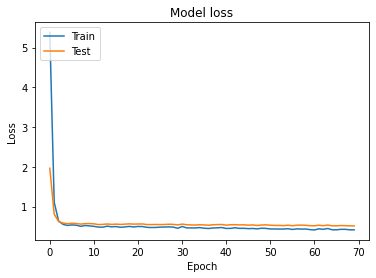

Kappa Score: 0.4308035714285714

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.26012277603149414 sec
Time to train the word2vec model: 8.555063486099243 mins
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_19 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1

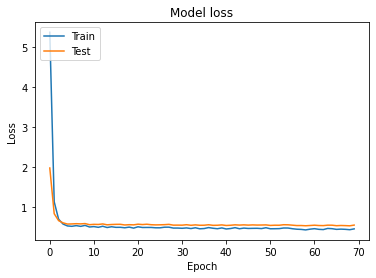

Kappa Score: 0.4639281129653402
Average kappa score value is : 0.4491351271745228

--------SET 3--------

(1726, 4)
(1726,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11465001106262207 sec
Time to train the word2vec model: 2.1772799491882324 mins
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_21 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-train

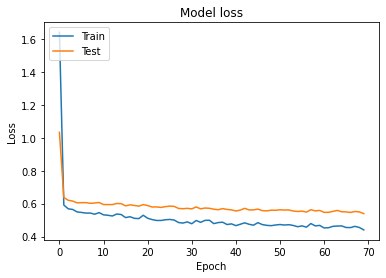

Kappa Score: 0.37824622030237576

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.10076594352722168 sec
Time to train the word2vec model: 2.1848223209381104 mins
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_23 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70

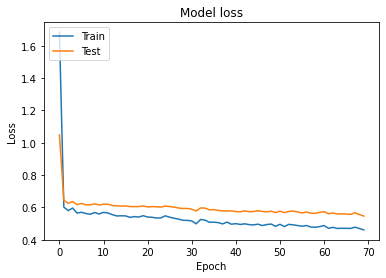

Kappa Score: 0.43236109278078405

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.10247254371643066 sec
Time to train the word2vec model: 2.214927911758423 mins
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_25 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


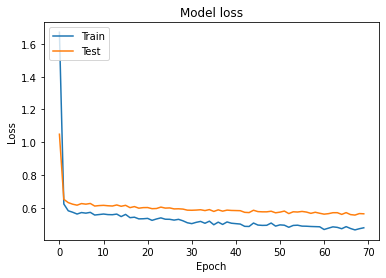

Kappa Score: 0.35625749700119946

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.10321426391601562 sec
Time to train the word2vec model: 2.1885085105895996 mins
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_14 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70

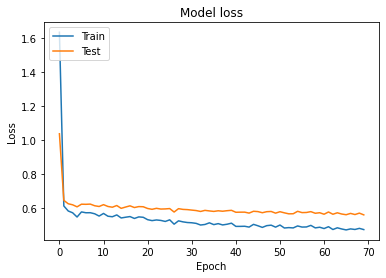

Kappa Score: 0.38100263852242744

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.10185909271240234 sec
Time to train the word2vec model: 2.165205955505371 mins
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_29 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


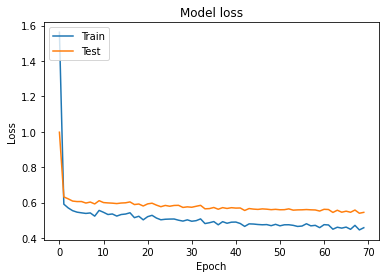

Kappa Score: 0.316661722913816
Average kappa score value is : 0.37290583430412055

--------SET 4--------

(1770, 4)
(1770,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.07589459419250488 sec
Time to train the word2vec model: 1.699512004852295 mins
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_31 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-traina

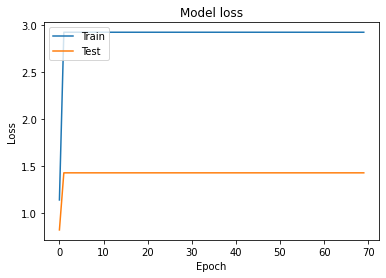

Kappa Score: 0.0

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.07567834854125977 sec
Time to train the word2vec model: 1.6969597339630127 mins
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_33 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1416/1416 [====

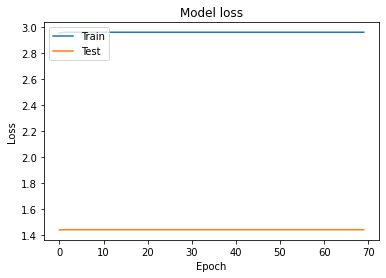

Kappa Score: 0.0

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.07494425773620605 sec
Time to train the word2vec model: 1.7165570259094238 mins
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_35 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1416/1416 [====

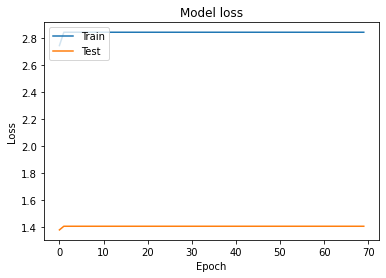

Kappa Score: 0.0

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.07524967193603516 sec
Time to train the word2vec model: 1.6358120441436768 mins
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_37 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_19 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1416/1416 [====

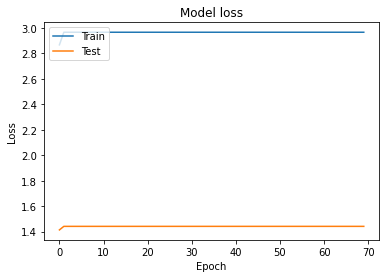

Kappa Score: 0.0

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.07580757141113281 sec
Time to train the word2vec model: 1.682042121887207 mins
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_39 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1416/1416 [=====

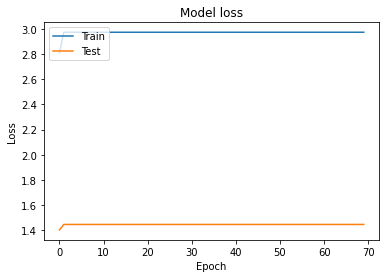

Kappa Score: 0.0
Average kappa score value is : 0.0

--------SET 5--------

(1805, 4)
(1805,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.10522055625915527 sec
Time to train the word2vec model: 2.5224337577819824 mins
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_41 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_21 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_______________

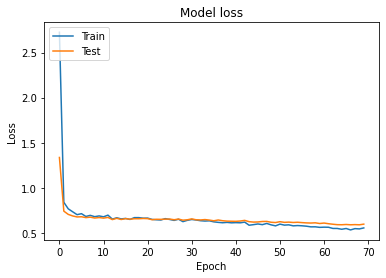

Kappa Score: 0.5511327203688938

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.10744452476501465 sec
Time to train the word2vec model: 2.601982831954956 mins
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_43 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_22 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1

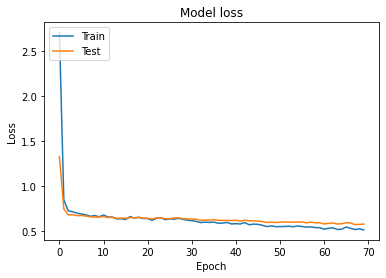

Kappa Score: 0.5271833588143604

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.10084843635559082 sec
Time to train the word2vec model: 2.571183204650879 mins
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_45 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_23 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1

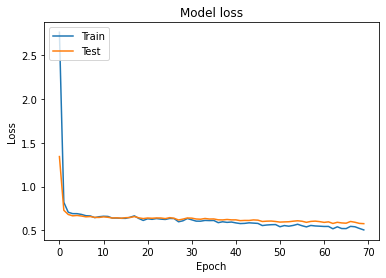

Kappa Score: 0.5436060998704276

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.10166358947753906 sec
Time to train the word2vec model: 2.61022686958313 mins
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_47 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
14

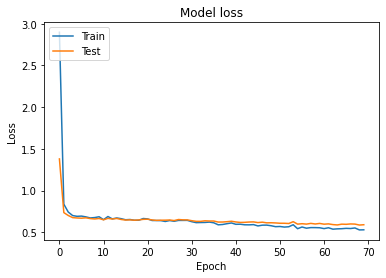

Kappa Score: 0.5346952103252121

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.10695171356201172 sec
Time to train the word2vec model: 2.609471321105957 mins
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_49 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_25 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1

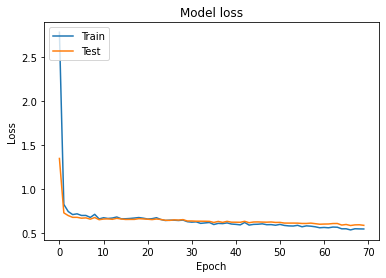

Kappa Score: 0.5960593529554852
Average kappa score value is : 0.5505353484668758

--------SET 6--------

(1800, 4)
(1800,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11388039588928223 sec
Time to train the word2vec model: 3.7647345066070557 mins
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_51 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-train

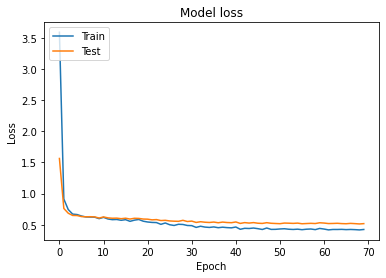

Kappa Score: 0.6844032624979193

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11828279495239258 sec
Time to train the word2vec model: 3.745845317840576 mins
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_53 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_54 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1

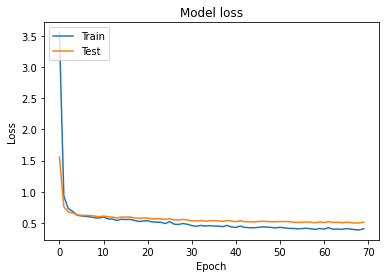

Kappa Score: 0.6516764839148165

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11356282234191895 sec
Time to train the word2vec model: 3.746948719024658 mins
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_55 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_56 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1

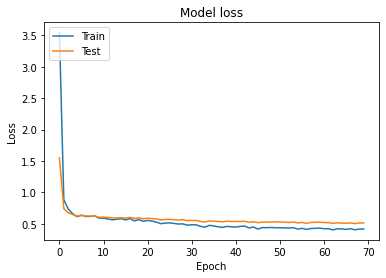

Kappa Score: 0.6902627511591963

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11386537551879883 sec
Time to train the word2vec model: 3.760929822921753 mins
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_57 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_58 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_29 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1

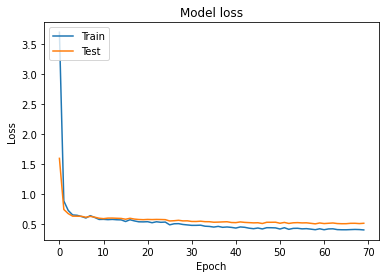

Kappa Score: 0.6692696371152963

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11177539825439453 sec
Time to train the word2vec model: 3.74564266204834 mins
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_59 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_30 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
14

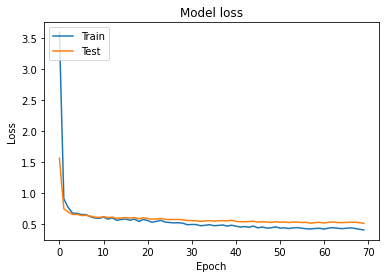

Kappa Score: 0.6854368932038835
Average kappa score value is : 0.6762098055782224

--------SET 7--------

(1569, 12)
(1569,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11403012275695801 sec
Time to train the word2vec model: 2.6068851947784424 mins
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_61 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_62 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_31 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trai

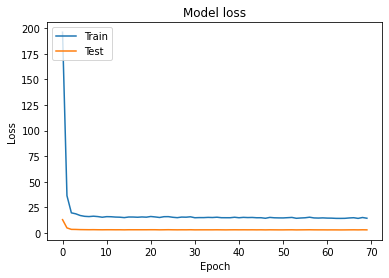

Kappa Score: 0.5722448373531612

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11784553527832031 sec
Time to train the word2vec model: 2.6329636573791504 mins
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_63 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_64 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_32 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


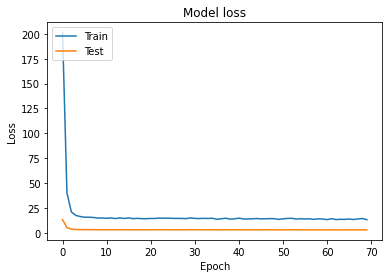

Kappa Score: 0.5305514870967014

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11901736259460449 sec
Time to train the word2vec model: 2.6486480236053467 mins
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_65 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_66 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_33 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


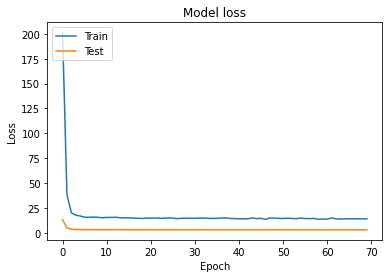

Kappa Score: 0.4939329354097284

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11491894721984863 sec
Time to train the word2vec model: 2.6387171745300293 mins
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_67 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_68 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_34 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


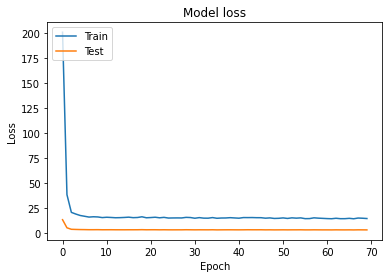

Kappa Score: 0.5686159728088649

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.11940550804138184 sec
Time to train the word2vec model: 2.646247148513794 mins
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_69 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_70 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_35 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
1

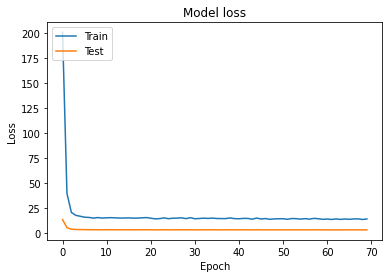

Kappa Score: 0.4923584460109499
Average kappa score value is : 0.5315407357358811

--------SET 8--------

(723, 16)
(723,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 2.5109870433807373 sec
Time to train the word2vec model: 5.419142246246338 mins
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_71 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_72 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_36 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainabl

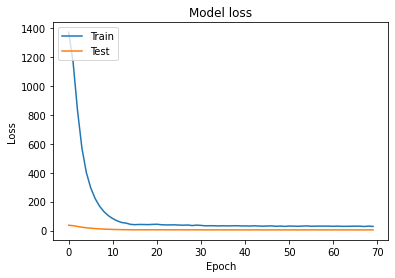

Kappa Score: 0.3679723400168441

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.1986532211303711 sec
Time to train the word2vec model: 5.398674964904785 mins
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_73 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_74 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_37 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
57

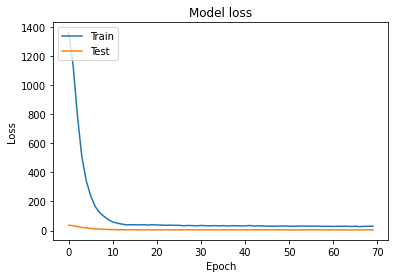

Kappa Score: 0.39736449631321513

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.18714141845703125 sec
Time to train the word2vec model: 5.236833095550537 mins
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_75 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_76 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_38 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


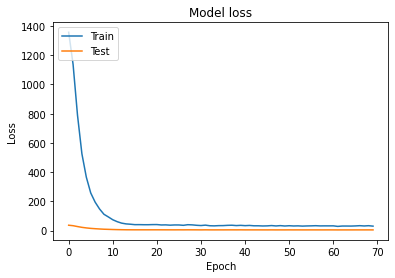

Kappa Score: 0.4476324370665592

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.19294214248657227 sec
Time to train the word2vec model: 5.454136371612549 mins
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_77 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_78 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_39 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
5

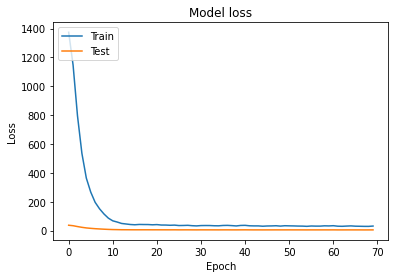

Kappa Score: 0.45641025641025645

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.19194602966308594 sec
Time to train the word2vec model: 5.196256160736084 mins
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_79 (Bidirectio (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_80 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_40 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


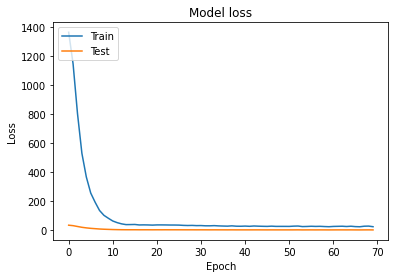

Kappa Score: 0.4067490531964879
Average kappa score value is : 0.41522571660067253


In [0]:
# Individual sets 
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
set_count = 1
all_sets_score = []
# Hyperparameters for word2vec
num_features = 400
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3
epochs = 30

# Hyperpaprameters for LSTM
Hidden_dim1=300
Hidden_dim2=100
return_sequences = True
dropout=0.5
recurrent_dropout=0.4
input_size=400
activation='relu'
bidirectional = True
batch_size = 64
epoch = 70
#####
####
import tensorflow as tf
tf.keras.backend.clear_session()

for s in sets:
  print("\n--------SET {}--------\n".format(set_count))
  set_count +=1
  X = s
  y = s['domain1_score']
  cv = KFold(n_splits=5, shuffle=True)
  #X, y = prepare_data(dataset_path=dataset_path)
  cv_data = cv.split(X)
  results = []
  prediction_list = []
  fold_count =1
  # hyperparameters for word2vec
  most_common_words= []
  print(X.shape)
  print(y.shape)
  for traincv, testcv in cv_data:
      print("\n--------Fold {}--------\n".format(fold_count))
      # get the train and test from the dataset.
      X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
      train_essays = X_train['essay']
      #print("y_train",y_train)
      test_essays = X_test['essay']
      #y_train = torch.tensor(y_train,dtype=torch.long)
      train_sentences = []
      # print("train_essay ",train_essays.shape)
      #print(X_train.shape,y_train.shape)
      for essay in train_essays:
          # get all the sentences from the essay
          train_sentences.append(essay_to_wordlist(essay, remove_stopwords = True))

      # word2vec embedding
      print("Converting sentences to word2vec model")
      model,_ = build_word2vec(train_sentences, num_workers, num_features, min_word_count, context,
                    downsampling)
      top10 = collections.defaultdict(int)

      # print("train_sentencesshap",len(train_sentences))
      trainDataVecs = np.array(getAvgFeatureVecs(train_sentences, model, num_features))
      test_sentences = []
      for essay_v in test_essays:
          test_sentences.append(essay_to_wordlist(essay_v, remove_stopwords=True))
      testDataVecs = np.array(getAvgFeatureVecs(test_sentences, model, num_features))
      trainDataVectors = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
      testDataVectors = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
      lstm_model = get_model_lstm(Hidden_dim1=Hidden_dim1, Hidden_dim2=Hidden_dim2, return_sequences=return_sequences,
                              dropout=dropout, recurrent_dropout=recurrent_dropout, input_size=input_size,
                              activation=activation, bidirectional=bidirectional)
      # print(trainDataVectors.shape)
      # print(y_train.shape)
      history = lstm_model.fit(trainDataVectors, y_train, batch_size=batch_size, epochs=epoch)
      plot_accuracy_curve(history)
      y_pred = lstm_model.predict(testDataVectors)
      y_pred = np.around(y_pred)
      np.nan_to_num(y_pred)
      result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
      print("Kappa Score: {}".format(result))
      results.append(result)
      fold_count += 1

  print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
  all_sets_score.append(results)


Below method is for running the model on whole dataset using the word2vec model.

(12976, 4)
(12976,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8619236946105957 sec
Time to train the word2vec model: 48.41549491882324 mins
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10380/10380 [==

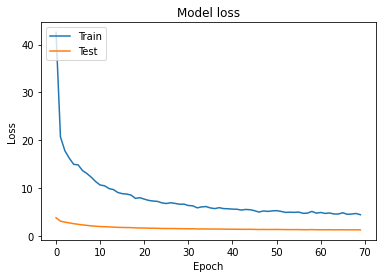

Kappa Score: 0.9690772488848252

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8998920917510986 sec
Time to train the word2vec model: 48.410395860672 mins
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10381

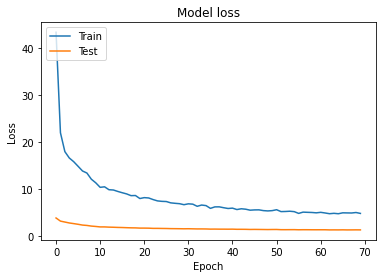

Kappa Score: 0.9723570173189542

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8663942813873291 sec
Time to train the word2vec model: 47.800869941711426 mins
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10

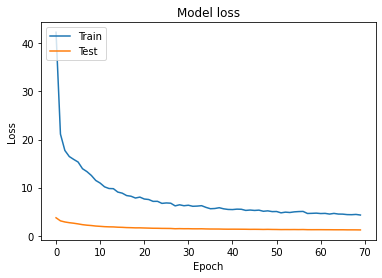

Kappa Score: 0.9681606637795384

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8679554462432861 sec
Time to train the word2vec model: 47.314122915267944 mins
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10

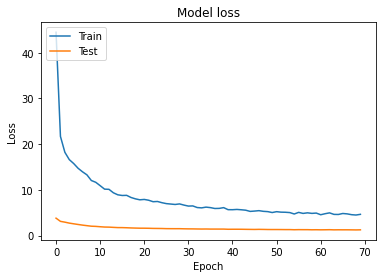

Kappa Score: 0.9725130742146156

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8937320709228516 sec
Time to train the word2vec model: 48.75269365310669 mins
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
103

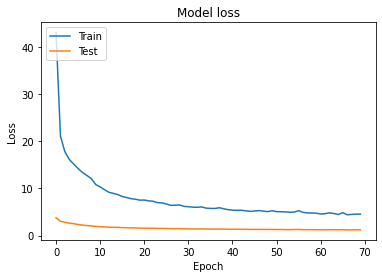

Kappa Score: 0.9569597144906096
Average kappa score value is : 0.9678135437377084


In [0]:
# Whole Dataset Word2vec
X= data
y = data['domain1_score']
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
set_count = 1
all_sets_score = []
# Hyperparameters for word2vec
num_features = 400
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3
epochs = 30

# Hyperpaprameters for LSTM
Hidden_dim1=300
Hidden_dim2=100
return_sequences = True
dropout=0.5
recurrent_dropout=0.4
input_size=400
activation='relu'
bidirectional = True
batch_size = 64
epoch = 70
#####
####
import tensorflow as tf
tf.keras.backend.clear_session()
cv = KFold(n_splits=5, shuffle=True)
#X, y = prepare_data(dataset_path=dataset_path)
cv_data = cv.split(X)
results = []
prediction_list = []
fold_count =1
# hyperparameters for word2vec
most_common_words= []
print(X.shape)
print(y.shape)
for traincv, testcv in cv_data:
    print("\n--------Fold {}--------\n".format(fold_count))
    # get the train and test from the dataset.
    X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
    train_essays = X_train['essay']
    #print("y_train",y_train)
    test_essays = X_test['essay']
    #y_train = torch.tensor(y_train,dtype=torch.long)
    train_sentences = []
    # print("train_essay ",train_essays.shape)
    #print(X_train.shape,y_train.shape)
    for essay in train_essays:
        # get all the sentences from the essay
        train_sentences.append(essay_to_wordlist(essay, remove_stopwords = True))

    # word2vec embedding
    print("Converting sentences to word2vec model")
    model,_ = build_word2vec(train_sentences, num_workers, num_features, min_word_count, context,
                  downsampling)
    top10 = collections.defaultdict(int)

    # print("train_sentencesshap",len(train_sentences))
    trainDataVecs = np.array(getAvgFeatureVecs(train_sentences, model, num_features))
    test_sentences = []
    for essay_v in test_essays:
        test_sentences.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    testDataVecs = np.array(getAvgFeatureVecs(test_sentences, model, num_features))
    trainDataVectors = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVectors = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    lstm_model = get_model_lstm(Hidden_dim1=Hidden_dim1, Hidden_dim2=Hidden_dim2, return_sequences=return_sequences,
                            dropout=dropout, recurrent_dropout=recurrent_dropout, input_size=input_size,
                            activation=activation, bidirectional=bidirectional)
    # print(trainDataVectors.shape)
    # print(y_train.shape)
    history = lstm_model.fit(trainDataVectors, y_train, batch_size=batch_size, epochs=epoch)
    plot_accuracy_curve(history)
    y_pred = lstm_model.predict(testDataVectors)
    y_pred = np.around(y_pred)
    np.nan_to_num(y_pred)
    result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    fold_count += 1

print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
